In [1]:
import pandas as pd

df= pd.read_csv(r"preprocessed.csv")


In [2]:
df.head()

,Unnamed: 0,index,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,...,Oil_level,Caudal_impulses,gpsLong,gpsLat,gpsSpeed,gpsQuality,cluster,timestamp,cluster_changed,rul
0,0,0,-0.012,9.758,9.760,-0.028,1.576,63.350,19.049625,3.9550,...,0,0,-8.65934,41.2124,0,1,0,2022-01-01 06:00:00,1,NaN
1,1,1,-0.012,9.760,9.760,-0.028,1.578,63.250,19.049625,4.0275,...,0,0,-8.65934,41.2124,0,1,0,2022-01-01 06:00:01,0,NaN
2,2,2,-0.010,9.760,9.760,-0.028,1.578,63.325,19.040281,3.9450,...,0,0,-8.65934,41.2124,0,1,0,2022-01-01 06:00:02,0,NaN
3,3,3,-0.012,9.756,9.756,-0.030,1.576,63.200,19.040281,3.9300,...,0,0,-8.65934,41.2124,0,1,0,2022-01-01 06:00:03,0,NaN
4,4,4,-0.012,9.756,9.756,-0.030,1.578,63.150,19.049625,3.9950,...,0,0,-8.65934,41.2124,0,1,0,2022-01-01 06:00:04,0,NaN


In [3]:
df['cluster_new'] = df['cluster'].apply(lambda x: 1 if x in [0, 1, 3] else 0 if x == 2 else x)

In [4]:
# Identify chunks based on your logic
df['cluster_changed'] = df['cluster_new'] != df['cluster_new'].shift(1)
df['cluster_changed'] = df['cluster_changed'].replace({True: 1, False: 0})

# Create a group identifier based on cumulative sum of cluster_changed
df['group'] = df['cluster_changed'].cumsum()

# Split the dataframe into chunks
chunks = [group for _, group in df.groupby('group')]

# Merge small chunks with adjacent ones
merged_chunks = []
current_chunk = chunks[0]

for i in range(1, len(chunks)):
    if len(current_chunk) < 100000:  # If current chunk has less than 10,000 rows
        current_chunk = pd.concat([current_chunk, chunks[i]])  # Merge with the next chunk
    else:
        merged_chunks.append(current_chunk)  # Add the chunk to the result
        current_chunk = chunks[i]

# Add the last chunk
if len(current_chunk) > 0:
    merged_chunks.append(current_chunk)

# Verify that all chunks have at least 10,000 rows
for i, chunk in enumerate(merged_chunks):
    print(f"Chunk {i+1}: {len(chunk)} rows")


C:\Users\hevar\AppData\Local\Temp\ipykernel_25608\2985294666.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['cluster_changed'] = df['cluster_changed'].replace({True: 1, False: 0})


Chunk 1: 100624 rows
Chunk 2: 100162 rows
Chunk 3: 100077 rows
Chunk 4: 100040 rows
Chunk 5: 100005 rows
Chunk 6: 100036 rows
Chunk 7: 221772 rows
Chunk 8: 100035 rows
Chunk 9: 100002 rows
Chunk 10: 104211 rows
Chunk 11: 100000 rows
Chunk 12: 100012 rows
Chunk 13: 100036 rows
Chunk 14: 119079 rows
Chunk 15: 100000 rows
Chunk 16: 100569 rows
Chunk 17: 100067 rows
Chunk 18: 100039 rows
Chunk 19: 254172 rows
Chunk 20: 107024 rows
Chunk 21: 100247 rows
Chunk 22: 138258 rows
Chunk 23: 100017 rows
Chunk 24: 100025 rows
Chunk 25: 100019 rows
Chunk 26: 100105 rows
Chunk 27: 107051 rows
Chunk 28: 100029 rows
Chunk 29: 100340 rows
Chunk 30: 100008 rows
Chunk 31: 100030 rows
Chunk 32: 101493 rows
Chunk 33: 108128 rows
Chunk 34: 213742 rows
Chunk 35: 107421 rows
Chunk 36: 100096 rows
Chunk 37: 179671 rows
Chunk 38: 100010 rows
Chunk 39: 100026 rows
Chunk 40: 100063 rows
Chunk 41: 127895 rows
Chunk 42: 199008 rows
Chunk 43: 100037 rows
Chunk 44: 103786 rows
Chunk 45: 100840 rows
Chunk 46: 100052 ro

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
import numpy as np
import pandas as pd

RUL_CAP = 3  # RUL cap in days

# Iterate through each DataFrame in chunks
for i, df in enumerate(merged_chunks):
    print(f"Processing chunk {i+1} with {len(df)} rows.")
    
    # Ensure 'timestamp' is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Calculate the maximum time for the current chunk
    max_time = df['timestamp'].max()

    # Compute RUL in days
    df['rul'] = (max_time - df['timestamp']).dt.total_seconds() / (24 * 3600)  # Convert to days

    # Cap the RUL at RUL_CAP days
    df['rul'] = df['rul'].clip(upper=RUL_CAP)  # Cap at RUL_CAP days

    # Convert 'rul' in days to Timedelta for consistency
    df['rul'] = pd.to_timedelta(df['rul'], unit='D')  

    # Compute reversed time for plotting
    df['reversed_time'] = max_time - df['timestamp']  # This is already a Timedelta

    # Optional: Preview the processed DataFrame
    # print(df[['timestamp', 'rul', 'reversed_time']].head())


Processing chunk 1 with 100624 rows.
Processing chunk 2 with 100162 rows.
Processing chunk 3 with 100077 rows.
Processing chunk 4 with 100040 rows.
Processing chunk 5 with 100005 rows.
Processing chunk 6 with 100036 rows.
Processing chunk 7 with 221772 rows.
Processing chunk 8 with 100035 rows.
Processing chunk 9 with 100002 rows.
Processing chunk 10 with 104211 rows.
Processing chunk 11 with 100000 rows.
Processing chunk 12 with 100012 rows.
Processing chunk 13 with 100036 rows.
Processing chunk 14 with 119079 rows.
Processing chunk 15 with 100000 rows.
Processing chunk 16 with 100569 rows.
Processing chunk 17 with 100067 rows.
Processing chunk 18 with 100039 rows.
Processing chunk 19 with 254172 rows.
Processing chunk 20 with 107024 rows.
Processing chunk 21 with 100247 rows.
Processing chunk 22 with 138258 rows.
Processing chunk 23 with 100017 rows.
Processing chunk 24 with 100025 rows.
Processing chunk 25 with 100019 rows.
Processing chunk 26 with 100105 rows.
Processing chunk 27 w

C:\Users\hevar\AppData\Local\Temp\ipykernel_25608\1643482945.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


Processing chunk 58 with 111918 rows.
Processing chunk 59 with 111316 rows.
Processing chunk 60 with 447480 rows.
Processing chunk 61 with 243577 rows.
Processing chunk 62 with 462092 rows.
Processing chunk 63 with 159365 rows.
Processing chunk 64 with 978344 rows.
Processing chunk 65 with 657733 rows.
Processing chunk 66 with 352912 rows.


In [7]:
merged_chunks[-3]

,Unnamed: 0,index,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,...,gpsLat,gpsSpeed,gpsQuality,cluster,timestamp,cluster_changed,rul,cluster_new,group,reversed_time
8784599,8784599,8784599,-0.008,8.492,8.228,-0.032,1.464,68.600,19.245844,3.6475,...,41.2114,30,1,2,2022-05-05 23:20:33,1,3 days 00:00:00,0,68160,13 days 15:45:29
8784600,8784600,8784600,-0.008,8.486,8.222,-0.030,1.466,68.525,19.255188,3.7200,...,41.2115,28,1,3,2022-05-05 23:20:34,1,3 days 00:00:00,1,68161,13 days 15:45:28
8784601,8784601,8784601,-0.008,8.484,8.218,-0.032,1.466,68.475,19.245844,3.7250,...,0.0000,0,0,1,2022-05-05 23:20:35,0,3 days 00:00:00,1,68161,13 days 15:45:27
8784602,8784602,8784602,-0.008,8.480,8.216,-0.030,1.466,68.550,19.255188,3.6375,...,41.2114,5,1,0,2022-05-05 23:20:36,0,3 days 00:00:00,1,68161,13 days 15:45:26
8784603,8784603,8784603,-0.008,8.460,8.198,-0.032,1.464,68.400,19.255188,3.7425,...,41.2114,1,1,0,2022-05-05 23:20:37,0,3 days 00:00:00,1,68161,13 days 15:45:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9762938,9762938,9762938,-0.008,9.266,8.884,-0.034,1.464,67.825,19.320594,3.6925,...,41.2119,1,1,0,2022-05-19 15:05:58,0,0 days 00:00:04,1,68165,0 days 00:00:04
9762939,9762939,9762939,-0.008,9.264,8.880,-0.032,1.466,67.825,19.311250,3.7950,...,41.2119,7,1,0,2022-05-19 15:05:59,0,0 days 00:00:02.999999998,1,68165,0 days 00:00:03
9762940,9762940,9762940,-0.006,9.264,8.880,-0.034,1.466,67.775,19.311250,3.6975,...,41.2119,14,1,3,2022-05-19 15:06:00,0,0 days 00:00:01.999999995,1,68165,0 days 00:00:02
9762941,9762941,9762941,-0.008,9.260,8.878,-0.032,1.466,67.800,19.311250,3.7025,...,41.2120,21,1,3,2022-05-19 15:06:01,0,0 days 00:00:01.000000002,1,68165,0 days 00:00:01


In [8]:
# Merge all DataFrames in merged_chunks into a single DataFrame
final_df = pd.concat(merged_chunks, ignore_index=True)

# Check the result
print(f"Final DataFrame has {len(final_df)} rows.")


Final DataFrame has 10773588 rows.


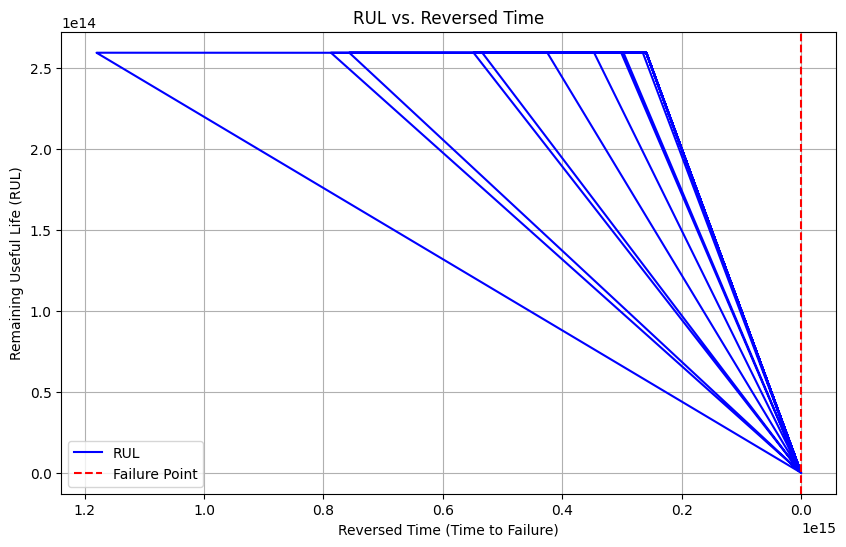

In [9]:
import matplotlib.pyplot as plt

df = final_df

# Plot RUL vs. reversed time
plt.figure(figsize=(10, 6))
plt.plot(df['reversed_time'], df['rul'], label='RUL', color='blue')

# Invert the X-axis to represent time to failure
plt.gca().invert_xaxis()
plt.axvline(x=0, color='red', linestyle='--', label='Failure Point')

# Add labels, legend, and grid
plt.xlabel('Reversed Time (Time to Failure)')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('RUL vs. Reversed Time')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
df.columns

Index(['Unnamed: 0', 'index', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality',
       'cluster', 'timestamp', 'cluster_changed', 'rul', 'cluster_new',
       'group', 'reversed_time'],
      dtype='object')

In [11]:
df.drop(["Unnamed: 0","index","timestamp","cluster_changed","cluster_new","group","reversed_time"], axis=1, inplace=True)

In [12]:
df.columns

Index(['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG',
       'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses', 'gpsLong',
       'gpsLat', 'gpsSpeed', 'gpsQuality', 'cluster', 'rul'],
      dtype='object')

# Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.layers import TimeDistributed, MaxPooling1D, Dropout

In [14]:
# Splitting features (X) and target (y)
X = df.drop(columns=['rul'])
y = df['rul']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA to reduce dimensions
pca = PCA(n_components=2)  # Keep 10 principal components (adjust as needed)
X_pca = pca.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [17]:
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)


MemoryError: Unable to allocate 12.2 TiB for an array with shape (6464152, 259189) and data type float64

In [ ]:
perceptron_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
perceptron_model.fit(X_train, y_train)
perceptron_preds = perceptron_model.predict(X_test)

In [ ]:
# LSTM Model
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
lstm_preds = lstm_model.predict(X_test_lstm).flatten()


In [ ]:
# CNN-LSTM Model
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(1, X_train.shape[1])))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(50, activation='relu'))
cnn_lstm_model.add(Dense(1))
cnn_lstm_model.compile(optimizer='adam', loss='mse')
cnn_lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
cnn_lstm_preds = cnn_lstm_model.predict(X_test_lstm).flatten()


In [ ]:
# Evaluation Metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, mae, rmse

In [ ]:
# Compare Models
results = {
    'Model': ['Logistic Regression', 'Perceptron', 'LSTM', 'CNN-LSTM'],
    'MSE': [
        calculate_metrics(y_test, lr_preds)[0],
        calculate_metrics(y_test, perceptron_preds)[0],
        calculate_metrics(y_test, lstm_preds)[0],
        calculate_metrics(y_test, cnn_lstm_preds)[0]
    ],
    'MAE': [
        calculate_metrics(y_test, lr_preds)[1],
        calculate_metrics(y_test, perceptron_preds)[1],
        calculate_metrics(y_test, lstm_preds)[1],
        calculate_metrics(y_test, cnn_lstm_preds)[1]
    ],
    'RMSE': [
        calculate_metrics(y_test, lr_preds)[2],
        calculate_metrics(y_test, perceptron_preds)[2],
        calculate_metrics(y_test, lstm_preds)[2],
        calculate_metrics(y_test, cnn_lstm_preds)[2]
    ]
}

results_df = pd.DataFrame(results)

In [ ]:
results_df